In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5
fig_height = 4
fig_format = :png
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "RzpcQ29udHJvbENoYWxsZW5nZXNTb2x1dGlvbnNcZG9jcw=="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


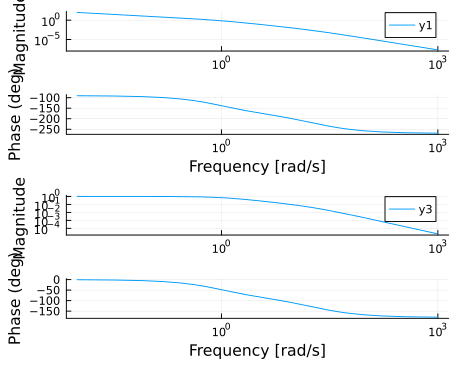

In [2]:
#| label: fig-bode
#| fig-cap: Starting Bode Plot

using DiscretePIDs, ControlSystems, Plots
using Plots
using LinearAlgebra

# System parameters
Ts = 0.02 # sampling time
Tf = 2.5; #final simulation time
g = 9.81 #gravity
α = 0.0 # slope
μ = 1.0 # friction coefficient
x_0 = -2.0 # starting position
dx_0 = 0.0 # starting velocity
τ = 20.0 # torque constant 

# State Space Matrix
A = [0 1 0
    0 -μ 1
    0 0 -τ
]*1.0;
B = [0
    0
    τ]*1.0;
C = [1 0 0
    0 1 0]*1.0

sys = ss(A, B, C, 0)      # Continuous

bodeplot(tf(sys))

3-element Vector{Float64}:
 -20.0
  -1.0
   0.0

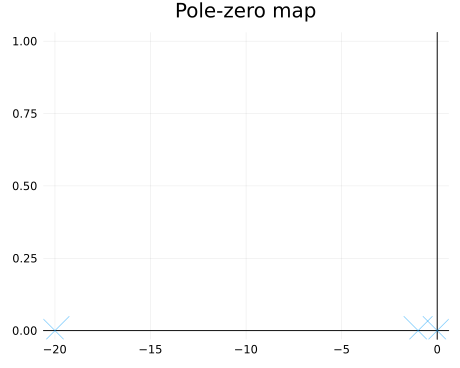

In [3]:
#| label: fig-pzmap
#| fig-cap: Starting PZ map
display(eigvals(A)) # -20 , -1, 0  
display(pzmap(tf(sys)))

In [4]:
print(observability(A, C)); #OK
print(controllability(A, B)); #OK
ϵ = 0.01;
pp = 15;
p = -2* [pp + ϵ , pp - ϵ , (pp / 4)];
L = real(place(sys, p, :c));

poles_obs = p*5
K = place(1.0*A',1.0*C', poles_obs)'
cont = observer_controller(sys, L, K; direct=false);

(isobservable = true, ranks = [3, 3, 3], sigma_min = [0.05255163155979671, 1.0000000000000002, 1.0])

(iscontrollable = true, ranks = [3, 3, 3], sigma_min = [18.82217025796643, 0.7247734159618929, 0.46815777001494974])

┌ Warning: Max iterations reached
└ @ ControlSystemsBase C:\Users\icpmoles\.julia\packages\ControlSystemsBase\IeuPW\src\synthesis.jl:310


ComplexF64[-150.09999999999997 + 0.0im, -149.89999999999995 + 0.0im, -7.500000000000134 + 0.0im, -29.979999999868912 + 0.0im, -30.020000000130636 + 0.0im, -37.50000000000044 + 0.0im]

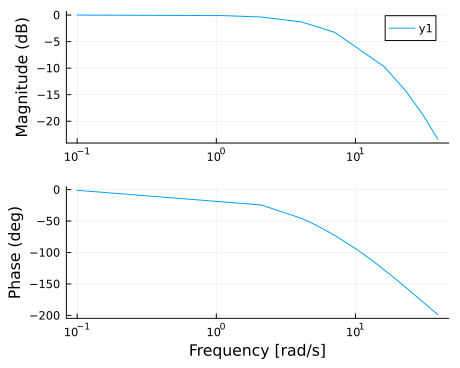

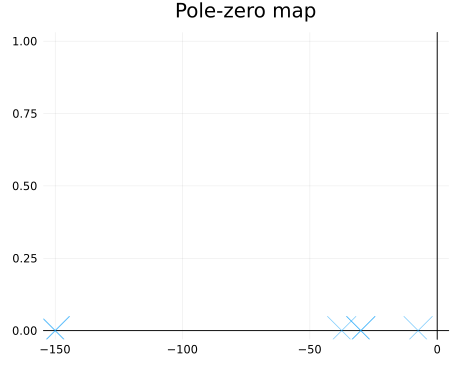

In [5]:
closedLoop = feedback(sys*cont)
print(poles(closedLoop));
setPlotScale("dB")
display(bodeplot(closedLoop[1, 1], 0.1:40))
display(pzmap(closedLoop))

In [6]:
K = L[1];
Ti = 0;
Td = L[2] / L[1];
pid = DiscretePID(; K, Ts, Ti, Td);

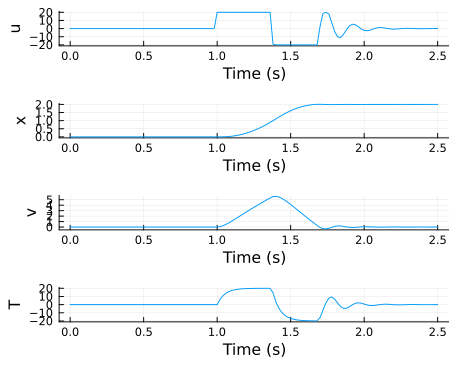

In [7]:
sysreal = ss(A, B, [1 0 0], 0)
ctrl = function (x, t)
    y = (sysreal.C*x)[] # measurement
    d = 0 * [1.0]        # disturbance
    r = 2 * (t >= 1) # reference
    # u = pid(r, y) # control signal
    # u + d # Plant input is control signal + disturbance
    # u =1
    e = x - [r; 0; 0]
    e[3] = 0 # torque not observable, just ignore it in the final feedback
    u = -L * e + d
    u = [maximum([-20 minimum([20 u])])]
end
t = 0:Ts:Tf


res = lsim(sysreal, ctrl, t)

plot(res, plotu=true, plotx=true, ploty=false);ylabel!("u", sp=1);ylabel!("x", sp=2);ylabel!("v", sp=3);ylabel!("T", sp=4)

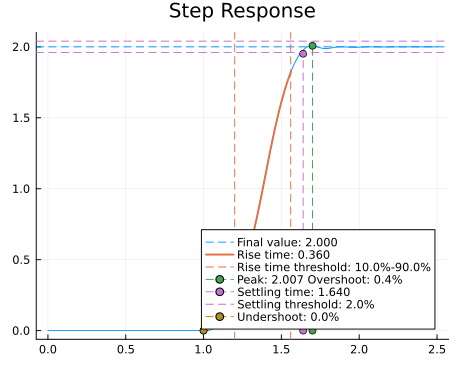

In [8]:
si = stepinfo(res);
plot(si);title!("Step Response")

Simulating ME-FMU ...   0%|█                             |  ETA: N/A

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:11


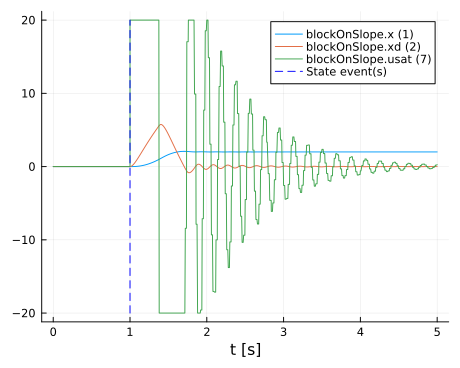

In [9]:
using FMI, DifferentialEquations
fmu = loadFMU(raw"G:\ControlChallengesSolutions\modelica\ControlChallenges\ControlChallenges.BlockOnSlope_Challenges.Examples.WithFriction.fmu");
simData = simulateME(fmu, (0.0, 5.0); recordValues=["blockOnSlope.x","blockOnSlope.xd","blockOnSlope.usat"]);
unloadFMU(fmu);
plot(simData, states=false, timeEvents=false)